
--- Pipeline Results ---
Similarity Score: 2588.05
Final Box: [759, 355, 1349, 495]
Processing Time: 63.21 seconds
Image successfully cropped and saved to './output/cropped_WhatsApp Image 2025-08-12 at 13.45.20.jpeg'


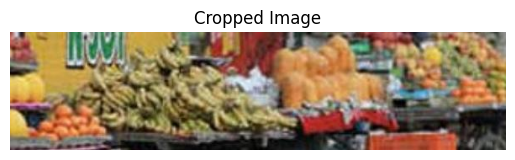


--- Visualizations ---


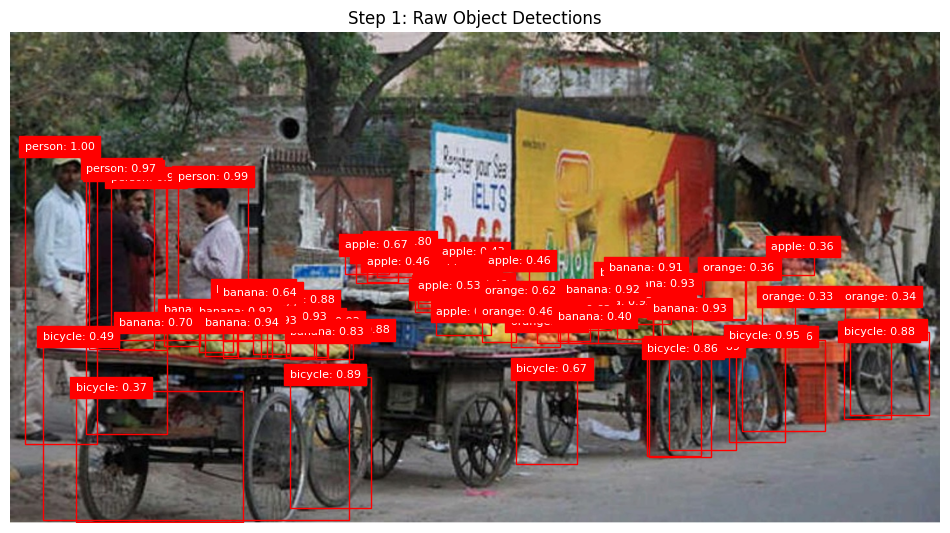

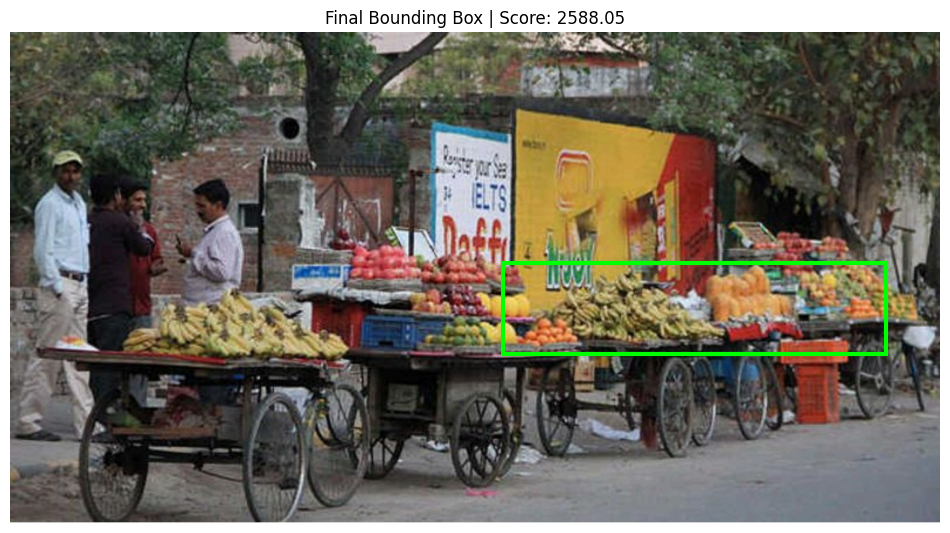


Notebook execution finished.


In [2]:
# Installation and imports
import sys
import os
import cv2
import torch
import numpy as np
import logging
import time
from typing import List, Dict, Any, Optional, Tuple
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection, CLIPProcessor, CLIPModel
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Configuration Class
class DetectionConfig:
    """
    Configuration parameters for the scene analysis pipeline.
    
    This class holds all the tunable parameters for the entire process,
    from object detection confidence thresholds to image padding factors.
    It centralizes configuration, making it easy to adjust the pipeline's
    behavior without changing the core logic.
    """
    def __init__(self):
        self.yolos_model_name: str = "hustvl/yolos-small"
        self.clip_model_name: str = "openai/clip-vit-base-patch32"
        # Adjusted for higher recall: a lower confidence threshold to capture more objects.
        self.yolos_confidence_threshold: float = 0.3
        self.yolos_iou_threshold: float = 0.4
        self.proximity_threshold_factor: float = 0.08
        self.min_group_size: int = 2
        # Keeping IoU thresholds for balanced filtering.
        self.iou_thresholds: List[float] = [0.2, 0.4, 0.6]
        self.margin_padding_factor: float = 0.1
        self.score_calibration_factor: float = 100.0
        self.fallback_top_k: int = 5

# --- Core Classes
class EnhancedObjectDetector:
    """
    Step 1: Enhanced Object Detection
    This class is responsible for identifying individual objects in an image. It leverages
    the YOLOS model, a state-of-the-art object detection transformer. The process includes
    loading the pre-trained model and its feature extractor, then using them to predict
    bounding boxes and labels for all detected objects above a certain confidence threshold.
    """
    def __init__(self, config: DetectionConfig):
        self.config = config
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logging.info(f"Using device: {self.device}")
        try:
            self.feature_extractor = YolosFeatureExtractor.from_pretrained(config.yolos_model_name)
            self.model = YolosForObjectDetection.from_pretrained(config.yolos_model_name).to(self.device)
            self.model.eval()
            logging.info("YOLOS model loaded successfully.")
        except Exception as e:
            logging.error(f"Failed to load YOLOS model: {e}")
            raise

    def detect_objects_yolos(self, image: Image.Image) -> List[Dict[str, Any]]:
        """Detects objects in a single image using the YOLOS model."""
        if image is None:
            logging.error("Input image is None.")
            return []
        try:
            inputs = self.feature_extractor(images=image, return_tensors="pt").to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)

            target_sizes = torch.tensor([image.size[::-1]]).to(self.device)
            results = self.feature_extractor.post_process_object_detection(
                outputs, threshold=self.config.yolos_confidence_threshold, target_sizes=target_sizes
            )[0]
            
            detections = []
            for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                box_int = [int(round(i.item())) for i in box]
                detections.append({
                    'box': box_int,
                    'label': self.model.config.id2label[label.item()],
                    'score': score.item()
                })

            logging.info(f"Found {len(detections)} objects.")
            return detections
        except Exception as e:
            logging.error(f"Error during object detection: {e}")
            return []

class SpatialGrouper:
    """
    Step 2: Improved Object Grouping
    This class groups detected objects that are spatially close to each other.
    Instead of simple distance checks, it uses **DBSCAN**, a clustering algorithm,
    to intelligently find clusters of objects. The key is that a valid group
    must contain a mix of "main objects" (e.g., "person") and "contextual objects"
    (e.g., "bananas") as defined by the user's query. This ensures the groups are
    semantically meaningful, not just random collections of nearby items.
    """
    def __init__(self, config: DetectionConfig):
        self.config = config

    def get_center(self, box: List[int]) -> Tuple[int, int]:
        """Calculates the center of a bounding box."""
        x1, y1, x2, y2 = box
        return ((x1 + x2) // 2, (y1 + y2) // 2)

    def group_objects(self, detections: List[Dict], main_objects: List[str], contextual_objects: List[str], image_dims: Tuple[int, int]) -> List[List[Dict]]:
        """Groups relevant objects based on spatial proximity using DBSCAN clustering,
           enforcing the presence of both main and contextual objects."""
        all_relevant_objects = []
        for d in detections:
            if d['label'] in main_objects or d['label'] in contextual_objects:
                all_relevant_objects.append(d)

        if len(all_relevant_objects) < 2:
            logging.warning("Not enough relevant objects found for grouping.")
            return []

        h, w = image_dims
        proximity_threshold = self.config.proximity_threshold_factor * min(h, w)
        logging.info(f"Using adaptive proximity threshold: {proximity_threshold:.2f} pixels")

        centers = np.array([self.get_center(d['box']) for d in all_relevant_objects])
        db = DBSCAN(eps=proximity_threshold, min_samples=self.config.min_group_size).fit(centers)
        labels = db.labels_

        unique_labels = set(labels)
        groups = []
        for label in unique_labels:
            if label == -1:  # Noise points, ignore
                continue
            group_members = [all_relevant_objects[i] for i, l in enumerate(labels) if l == label]
            
            # Check if the group contains at least one of each required object type
            has_main_object = any(d['label'] in main_objects for d in group_members)
            has_contextual_object = any(d['label'] in contextual_objects for d in group_members)

            if has_main_object and has_contextual_object:
                groups.append(group_members)

        if not groups:
            logging.warning("No significant groups found after clustering with required objects.")
            return []

        logging.info(f"Found {len(groups)} potential groups.")
        return groups

class BoundingBoxOptimizer:
    """
    Step 3 & 4: Smart Bounding Box Generation and Multi-Level Filtering
    This class first creates a single, large bounding box that encompasses all
    the objects in a group. Then, it refines these candidates using a cascaded
    Intersection over Union (IoU) filtering strategy. This means it checks
    if each individual object's box overlaps sufficiently with the new group box,
    using multiple thresholds to ensure the final group is coherent and tightly bound.
    """
    def __init__(self, config: DetectionConfig):
        self.config = config

    def create_encompassing_box(self, group: List[Dict]) -> Optional[List[int]]:
        """Creates a single bounding box that encompasses all boxes in a group."""
        if not group:
            return None
        x1_min = min(d['box'][0] for d in group)
        y1_min = min(d['box'][1] for d in group)
        x2_max = max(d['box'][2] for d in group)
        y2_max = max(d['box'][3] for d in group)
        return [x1_min, y1_min, x2_max, y2_max]

    def iou(self, box1: List[int], box2: List[int]) -> float:
        """Calculates the Intersection over Union (IoU) of two boxes."""
        x1_inter = max(box1[0], box2[0])
        y1_inter = max(box1[1], box2[1])
        x2_inter = min(box1[2], box2[2])
        y2_inter = min(box1[3], box2[3])

        intersection_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union_area = box1_area + box2_area - intersection_area

        return intersection_area / union_area if union_area > 0 else 0

    def multi_level_iou_filtering(self, detections: List[Dict], candidate_boxes: List[List[int]]) -> List[List[Dict]]:
        """Applies cascaded IoU filtering to select the best group."""
        filtered_groups = []
        for box in candidate_boxes:
            filtered_detections_per_box = []
            for d in detections:
                for threshold in self.config.iou_thresholds:
                    if self.iou(box, d['box']) >= threshold:
                        filtered_detections_per_box.append(d)
                        break
            if filtered_detections_per_box:
                filtered_groups.append(filtered_detections_per_box)

        if not filtered_groups:
            logging.warning("No groups survived multi-level IoU filtering.")
            return []
        
        logging.info(f"Found {len(filtered_groups)} groups after multi-level IoU filtering.")
        return filtered_groups

class SimilarityScorer:
    """
    Step 5: Enhanced Similarity Scoring
    This class scores how well a candidate group's bounding box matches the user's
    text query. It uses the **CLIP** model, which is excellent at understanding the
    relationship between images and text. It crops the image to each candidate box,
    then uses CLIP to get a numerical similarity score. The scores are calibrated
    to be more meaningful for comparison.
    """
    def __init__(self, config: DetectionConfig):
        self.config = config
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        try:
            self.processor = CLIPProcessor.from_pretrained(config.clip_model_name)
            self.model = CLIPModel.from_pretrained(config.clip_model_name).to(self.device)
            self.model.eval()
            logging.info("CLIP model loaded successfully.")
        except Exception as e:
            logging.error(f"Failed to load CLIP model: {e}")
            raise

    def get_similarity_score_clip(self, image_region: Image.Image, query: str) -> float:
        """Calculates the CLIP similarity score between an image region and a text query."""
        if image_region is None:
            return 0.0
        try:
            inputs = self.processor(text=[query], images=image_region, return_tensors="pt", padding=True).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)

            calibrated_score = outputs.logits_per_image.item() * self.config.score_calibration_factor
            return calibrated_score
        except Exception as e:
            logging.error(f"Error during CLIP scoring: {e}")
            return 0.0

class SceneAnalysisPipeline:
    """
    Main pipeline orchestrating all steps from detection to scoring.

    This is the central class that manages the entire workflow. It takes an image
    and a text query as input, then directs the process through object detection,
    spatial grouping, bounding box optimization, and similarity scoring to find
    the single best region in the image that matches the query. It also includes
    a fallback strategy for cases where no groups are found.
    """
    def __init__(self, config: DetectionConfig):
        self.config = config
        self.detector = EnhancedObjectDetector(config)
        self.grouper = SpatialGrouper(config)
        self.box_optimizer = BoundingBoxOptimizer(config)
        self.scorer = SimilarityScorer(config)

    def _parse_query_for_specific_objects(self, query: str) -> Tuple[List[str], List[str]]:
        """
        Parses the query to extract main and contextual object keywords.
        
        This method is now more robust, looking for a wider range of synonyms
        and related terms to improve the grouping stage.
        """
        main_objects = []
        contextual_objects = []
        
        # More comprehensive keyword mapping for main objects
        main_object_keywords = ["vendor", "person", "man", "woman", "seller"]
        contextual_object_keywords = ["bananas", "fruit", "vegetables", "produce", "apple", "orange", "food"]
        
        for keyword in main_object_keywords:
            if keyword in query.lower():
                main_objects.append("person") # YOLOS labels people as 'person'
                break
        
        for keyword in contextual_object_keywords:
            if keyword in query.lower():
                # We need to map these to specific YOLOS labels
                if "bananas" in query.lower() or "fruit" in query.lower():
                    contextual_objects.extend(["banana", "apple", "orange"])
                if "vegetables" in query.lower():
                    contextual_objects.extend(["broccoli", "carrot", "cucumber"])
                # Add more mappings as needed
                break
        
        return main_objects, contextual_objects

    def _fallback_strategy(self, image: Image.Image, query: str, detections: List[Dict]) -> Tuple[Optional[List[int]], float, List[Dict]]:
        """
        Handles the fallback case by scoring single detections.

        If the primary grouping strategy fails to find any meaningful groups,
        this method provides a backup plan. It takes the top-k individual
        detections (e.g., a single "person" or a single "banana") and scores them
        against the query using CLIP. It then returns the combined bounding box
        of the highest-scoring single detections, ensuring a result is still
        returned even in complex or sparse scenes.
        """
        logging.warning("Falling back to top-k single detections.")
        scored_detections = []
        # Fallback now uses the enriched prompts for better scoring
        prompts = self._get_enriched_prompts(query)
        
        for detection in detections:
            box = detection['box']
            cropped_image = image.crop(box)
            # Calculate average score from multiple prompts
            scores = [self.scorer.get_similarity_score_clip(cropped_image, p) for p in prompts]
            avg_score = sum(scores) / len(scores)
            scored_detections.append({'detection': detection, 'score': avg_score})
        
        scored_detections.sort(key=lambda x: x['score'], reverse=True)
        top_k_detections = scored_detections[:self.config.fallback_top_k]
        
        if not top_k_detections:
            return None, 0.0, []

        best_group = [d['detection'] for d in top_k_detections]
        final_box = self.box_optimizer.create_encompassing_box(best_group)
        final_score = top_k_detections[0]['score']
        
        logging.info(f"Fallback: Found {len(best_group)} top detections.")
        return final_box, final_score, best_group

    def _get_enriched_prompts(self, query: str) -> List[str]:
        """Generates a list of semantically similar prompts for robust CLIP scoring."""
        # This function provides a more stable score by using a few related prompts
        return [
            query,
            f"A photo of {query}",
            f"An image showing {query}",
            f"A close-up of a scene with {query}"
        ]

    def analyze_scene(self, image_path: str, query: str) -> Any:
        """Executes the full scene analysis pipeline for a given image and query."""
        start_time = time.time()
        try:
            # 1. Load and Preprocess Image
            logging.info(f"Processing image: {image_path} with query: '{query}'")
            image = Image.open(image_path).convert("RGB")
            image_dims = image.size[::-1]

            # 2. Enhanced Object Detection
            detections = self.detector.detect_objects_yolos(image)
            if not detections:
                return "No objects detected."

            # 3. Improved Object Grouping (Now more specific)
            main_objects, contextual_objects = self._parse_query_for_specific_objects(query)
            grouped_candidates = self.grouper.group_objects(detections, main_objects, contextual_objects, image_dims)

            final_box, similarity_score, best_group = None, 0.0, []

            if not grouped_candidates:
                # Fallback to scoring individual detections if no groups are found
                final_box, similarity_score, best_group = self._fallback_strategy(image, query, detections)
                if not final_box:
                    return "No relevant groups or fallback detections found."
            else:
                # 4. Smart Bounding Box Generation & Multi-Level IoU Filtering
                candidate_boxes = [self.box_optimizer.create_encompassing_box(group) for group in grouped_candidates]
                filtered_groups = self.box_optimizer.multi_level_iou_filtering(detections, candidate_boxes)

                if not filtered_groups:
                    return "No groups survived filtering."

                # 5. Enhanced Similarity Scoring & Selection
                final_box, similarity_score, best_group = self._process_candidate_groups(image, query, filtered_groups)

            if final_box:
                # 6. Optimized Final Bounding Box
                # This step expands the final bounding box slightly to include more context.
                # It prevents the box from being too tight, which can sometimes look unnatural
                # and might miss important contextual elements right at the edge.
                x1, y1, x2, y2 = final_box
                width, height = x2 - x1, y2 - y1
                padding = self.config.margin_padding_factor * min(width, height)
                
                final_box = [
                    max(0, int(x1 - padding)),
                    max(0, int(y1 - padding)),
                    min(image.width, int(x2 + padding)),
                    min(image.height, int(y2 + padding))
                ]
                logging.info(f"Final refined bounding box: {final_box}")
            else:
                return "Final box could not be generated."

            logging.info(f"Final similarity score: {similarity_score:.2f}")

            # Prepare results object
            results = {
                "image_path": image_path,
                "query": query,
                "detections": detections,
                "grouped_candidates": grouped_candidates,
                "best_group": best_group,
                "final_box": final_box,
                "similarity_score": similarity_score,
                "processing_time": time.time() - start_time
            }
            logging.info(f"Pipeline completed in {results['processing_time']:.2f} seconds.")
            return results

        except Exception as e:
            logging.error(f"An error occurred in the pipeline: {e}")
            return f"Pipeline failed: {e}"

    def _process_candidate_groups(self, image: Image.Image, query: str, filtered_groups: List[List[Dict]]) -> Tuple[Optional[List[int]], float, List[Dict]]:
        """
        Crops, scores, and selects the best group from a list of candidates.
        
        Now uses enriched prompts to get a more reliable average score.
        """
        best_score = -1.0
        best_group = []
        best_box = None
        
        enriched_prompts = self._get_enriched_prompts(query)

        for group in filtered_groups:
            box = self.box_optimizer.create_encompassing_box(group)
            if box:
                cropped_image = image.crop(box)
                # Calculate average score from multiple prompts
                scores = [self.scorer.get_similarity_score_clip(cropped_image, p) for p in enriched_prompts]
                avg_score = sum(scores) / len(scores)
                
                if avg_score > best_score:
                    best_score = avg_score
                    best_group = group
                    best_box = box
        
        return best_box, best_score, best_group

    def visualize(self, results: Dict, step: str = "final"):
        """
        Generates professional visualizations using matplotlib.

        This function creates visual representations of the pipeline's different stages.
        You can choose to visualize the raw object detections, the clustered groups,
        or the final, refined bounding box. This is an excellent tool for debugging
        and understanding how the pipeline arrives at its final conclusion.
        """
        if isinstance(results, str):
            logging.warning("Cannot visualize due to an error in the pipeline.")
            return
        
        fig, ax = plt.subplots(1, figsize=(12, 12))
        image = Image.open(results['image_path']).convert("RGB")
        ax.imshow(image)
        ax.set_title(f"Scene Analysis for: '{results['query']}'")
        
        if step == 'detections':
            for det in results['detections']:
                x1, y1, x2, y2 = det['box']
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x1, y1, f"{det['label']}: {det['score']:.2f}", color='white', fontsize=8, backgroundcolor='red')
            plt.title("Step 1: Raw Object Detections")
        elif step == 'grouping':
            for i, group in enumerate(results['grouped_candidates']):
                color = np.random.rand(3,)
                for det in group:
                    x1, y1, x2, y2 = det['box']
                    # Draw a box around each object in the group
                    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)
                
                # Draw the encompassing box for the group and label it
                encompassing_box = self.box_optimizer.create_encompassing_box(group)
                if encompassing_box:
                    ex1, ey1, ex2, ey2 = encompassing_box
                    group_rect = Rectangle((ex1, ey1), ex2 - ex1, ey2 - ey1, linewidth=3, edgecolor=color, facecolor='none', linestyle='--')
                    ax.add_patch(group_rect)
                    plt.text(ex1, ey1 - 5, f"Group {i+1}", color='white', fontsize=10, backgroundcolor=color)
            plt.title("Step 2: Object Grouping")
        elif step == 'final':
            if results['final_box']:
                x1, y1, x2, y2 = results['final_box']
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=3, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                plt.title(f"Final Bounding Box | Score: {results['similarity_score']:.2f}")
            else:
                plt.title("Final Bounding Box (Not Found)")
        
        plt.axis('off')
        plt.show()

def save_cropped_image(input_image_path: str, bbox: List[int], output_image_path: str):
    """
    Crops an image based on a bounding box and saves it.
    
    This utility function takes the final, optimized bounding box coordinates
    and uses them to crop the original image. It then saves the cropped
    portion to a specified file path. This is useful for post-processing or
    to get a clean image of the identified scene.
    
    Args:
        input_image_path (str): Path to the original image.
        bbox (List[int]): Bounding box coordinates [x1, y1, x2, y2].
        output_image_path (str): Path to save the cropped image.
    """
    try:
        image = Image.open(input_image_path)
        cropped_image = image.crop(tuple(bbox))
        os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
        cropped_image.save(output_image_path)
        print(f"Image successfully cropped and saved to '{output_image_path}'")
    except FileNotFoundError:
        print(f"Error: The file '{input_image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

def display_cropped_image(image_path: str):
    """
    Displays an image from a given file path using matplotlib.
    Args:
        image_path (str): The file path of the image to display.
    """
    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title("Cropped Image")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: The cropped image file '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred while displaying the image: {e}")

# --- Main Execution Block ---
if __name__ == '__main__':
    # Hardcoded inputs based on user request.
    image_path = "/kaggle/input/image-path/WhatsApp Image 2025-08-12 at 13.45.20.jpeg"
    query = "oranges"
    output_dir = "./output"

    logging.info("Starting the scene analysis pipeline...")
    
    if not os.path.exists(image_path):
        logging.error(f"Image not found at the specified path: {image_path}")
        sys.exit(1)

    config = DetectionConfig()
    pipeline = SceneAnalysisPipeline(config)
    
    result = pipeline.analyze_scene(image_path=image_path, query=query)
    
    if isinstance(result, dict):
        print("\n--- Pipeline Results ---")
        print(f"Similarity Score: {result['similarity_score']:.2f}")
        print(f"Final Box: {result['final_box']}")
        print(f"Processing Time: {result['processing_time']:.2f} seconds")

        output_image_path = os.path.join(output_dir, f"cropped_{os.path.basename(image_path)}")
         
        # Check if a final box was found before attempting to crop and display
        if result['final_box']:
            save_cropped_image(result['image_path'], result['final_box'], output_image_path)
            # Display the newly cropped image
            display_cropped_image(output_image_path)
        else:
            print("No final bounding box to crop.")

        print("\n--- Visualizations ---")
        pipeline.visualize(result, step='detections')
        #pipeline.visualize(result, step='grouping')
        pipeline.visualize(result, step='final')
    else:
        print(f"\nPipeline failed to complete: {result}")
    
    print("\nNotebook execution finished.")